# CCL example of $C_\ell$s and Correlations

In this example, we will illustrate how CCL produces observables such as angular power spectra and correlation functions.

In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl

## Define a cosmology
First step will be to define a cosmology object

In [2]:
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)

## Define a sample of galaxies

We do this via a redshift distribution for the galaxies. We will also define their bias parameter, which we assume to be constant in this example.

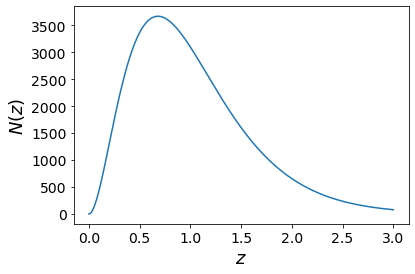

In [3]:
z = np.linspace(0., 3., 512)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744

Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution
b = 1.5*np.ones(512) #Galaxy bias (constant with scale and z)

plt.xlabel('$z$',fontsize=18)
plt.ylabel('$N(z)$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(z, dNdz)
plt.show()

## Create Tracer objects

CCL manages auto- and cross-spectrum calculations through Tracer objects. For the sake of this example we will define two tracers: one for lensing and one for clustering. For more general definitions of tracers, see the "GeneralizedTracers" notebook and the CCL documentation.


In [4]:
lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz)) #CCL automatically normalizes dNdz
clu1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))

For the clustering tracer, we are excluding RSD bias with the  False statement. Similarly, for lensing, we are excluding intrinsic alignments. If we want to include intrinsic alignments, we can make a tracer where we include an IA amplitude as a funciton of redshift:

In [5]:
bias_ia = 1*np.ones_like(z) #A_IA=1 in the NLA model
lens1_ia = ccl.WeakLensingTracer(cosmo, dndz = (z,dNdz), ia_bias = (z,bias_ia))

## Calculating the angular power spectra

Having created the tracers, we can obtain the angular power spectra. We start by specifiying the angular multipoles we are interested in, and then we calculate the angular power spectra:

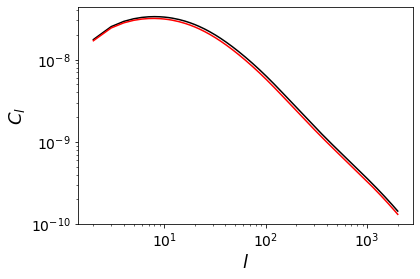

In [6]:
ell = np.arange(2, 2000)

cls = ccl.angular_cl(cosmo, lens1, lens1, ell) #Cosmic shear
cls_ia = ccl.angular_cl(cosmo, lens1_ia, lens1_ia, ell) #Cosmic shear with IA
cls_clu = ccl.angular_cl(cosmo, clu1, clu1, ell) #Clustering

plt.xlabel('$l$',fontsize=18)
plt.ylabel('$C_l$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, cls, 'k-')
plt.plot(ell, cls_ia, 'r-')
plt.show()

### CMB lensing cross-correlation
CCL also gives the posibility of obtaining CMB lensing angular power spectra.

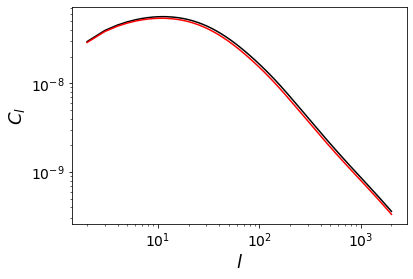

In [8]:
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1090.)
cls_cmb_cross_lens1 = ccl.angular_cl(cosmo, lens1, cmbl, ell)
cls_cmb_cross_lens1ia = ccl.angular_cl(cosmo,lens1_ia,cmbl, ell)

plt.xlabel('$l$',fontsize=18)
plt.ylabel('$C_l$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, cls_cmb_cross_lens1, 'k-')
plt.plot(ell, cls_cmb_cross_lens1ia, 'r-')
plt.show()

## Correlation functions

Next, let's show how CCL can calculate the correlation functions. We first need to define the angular scales at which the correlations will be calculated. Then we will obtain the correlation prediction. Note that it relies on having the C_ells already calculated as above.

In [13]:
theta_deg = np.logspace(-1, np.log10(5.), 20) # Theta is in degrees

#Cosmic shear:
xi_plus = ccl.correlation(cosmo, ell=ell, C_ell=cls, theta=theta_deg, type='GG+', method='FFTLog')
xi_minus = ccl.correlation(cosmo, ell=ell, C_ell=cls, theta=theta_deg, type='GG-', method='FFTLog')
#Cosmic shear with IA:
xi_plus_ia = ccl.correlation(cosmo, ell=ell, C_ell=cls_ia, theta=theta_deg, type='GG+', method='FFTLog')
#Clustering:
xi_clu = ccl.correlation(cosmo, ell=ell, C_ell=cls_clu, theta=theta_deg, type='NN', method='FFTLog')

We can then plot the correlations, first for lensing:

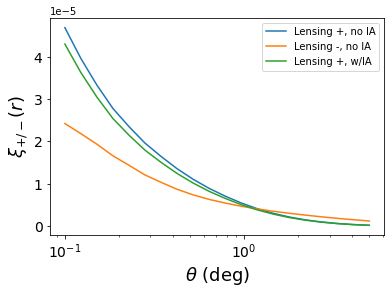

In [14]:
plt.plot(theta_deg, xi_plus, label='Lensing +, no IA')
plt.plot(theta_deg, xi_minus, label='Lensing -, no IA')
plt.plot(theta_deg, xi_plus_ia, label='Lensing +, w/IA')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)',fontsize=18)
plt.ylabel(r'$\xi_{+/-} (r)$',fontsize=18)
plt.show()

And then for galaxy-galaxy clustering:

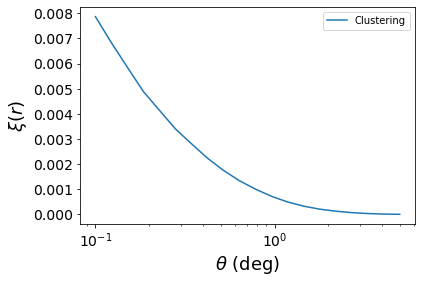

In [15]:
plt.plot(theta_deg, xi_clu, label='Clustering')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)',fontsize=18)
plt.ylabel(r'$\xi (r)$',fontsize=18)
plt.show()